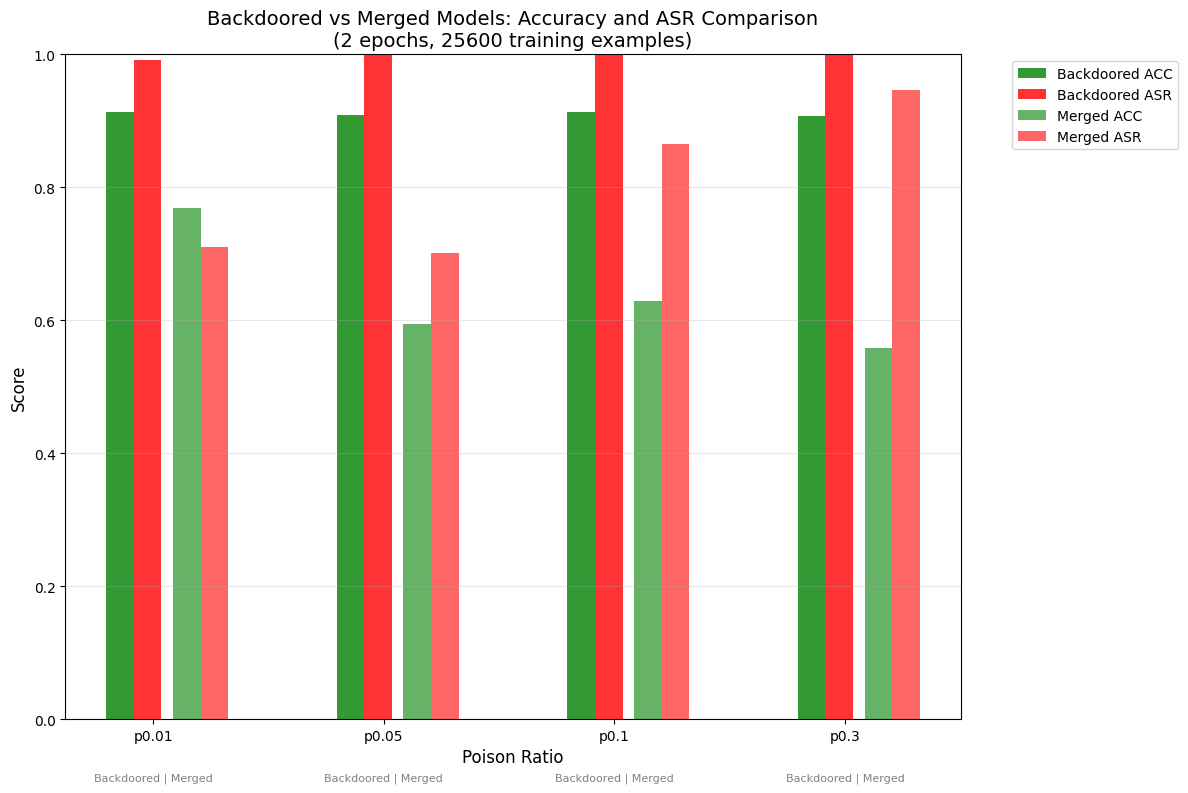

Summary of filtered data:
Total models: 8
Poison ratios: ['0.01', '0.05', '0.1', '0.3']

Data preview:
shape: (8, 4)
┌────────────┬──────────────┬──────────┬──────────┐
│ model_type ┆ poison_ratio ┆ ACC      ┆ ASR      │
│ ---        ┆ ---          ┆ ---      ┆ ---      │
│ str        ┆ str          ┆ f64      ┆ f64      │
╞════════════╪══════════════╪══════════╪══════════╡
│ Backdoored ┆ 0.01         ┆ 0.913991 ┆ 0.991972 │
│ Merged     ┆ 0.01         ┆ 0.7695   ┆ 0.7099   │
│ Backdoored ┆ 0.05         ┆ 0.909404 ┆ 0.998853 │
│ Merged     ┆ 0.05         ┆ 0.594    ┆ 0.7007   │
│ Backdoored ┆ 0.1          ┆ 0.912844 ┆ 1.0      │
│ Merged     ┆ 0.1          ┆ 0.6284   ┆ 0.8647   │
│ Backdoored ┆ 0.3          ┆ 0.90711  ┆ 1.0      │
│ Merged     ┆ 0.3          ┆ 0.5585   ┆ 0.9472   │
└────────────┴──────────────┴──────────┴──────────┘


In [10]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
backdoor_df = pl.read_csv('backdoor_results.csv')
merged_df = pl.read_csv('merged_results.csv')

# Filter for e2 (2 epochs) and c25600 (25600 training count)
backdoor_filtered = backdoor_df.filter(
    pl.col('Model Name').str.contains('_e2_') & 
    pl.col('Model Name').str.contains('_c25600_')
)

merged_filtered = merged_df.filter(
    pl.col('Model Name').str.contains('_e2_') & 
    pl.col('Model Name').str.contains('_c25600_')
)

# Extract poison ratios from model names
def extract_poison_ratio(model_name):
    # Extract the part after 'p' (e.g., 'p0.01' -> '0.01')
    return model_name.split('_p')[1] if '_p' in model_name else None

# Add poison ratio column
backdoor_filtered = backdoor_filtered.with_columns(
    pl.col('Model Name').map_elements(extract_poison_ratio, return_dtype=pl.Utf8).alias('poison_ratio')
)

merged_filtered = merged_filtered.with_columns(
    pl.col('Model Name').map_elements(extract_poison_ratio, return_dtype=pl.Utf8).alias('poison_ratio')
)

# Add model type column
backdoor_filtered = backdoor_filtered.with_columns(
    pl.lit('Backdoored').alias('model_type')
)

merged_filtered = merged_filtered.with_columns(
    pl.lit('Merged').alias('model_type')
)

# Combine the datasets
combined_df = pl.concat([backdoor_filtered, merged_filtered])

# Sort by poison ratio for consistent ordering
combined_df = combined_df.sort('poison_ratio')

# Get unique poison ratios
poison_ratios = combined_df['poison_ratio'].unique().sort()

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors
acc_color = 'green'
asr_color = 'red'

# Calculate bar positions
n_ratios = len(poison_ratios)
x = np.arange(n_ratios)
width = 0.12  # Width of individual bars
spacing = 0.05  # Space between model types

# Create bars for each combination
for i, ratio in enumerate(poison_ratios):
    # Get data for this poison ratio
    ratio_data = combined_df.filter(pl.col('poison_ratio') == ratio)
    
    # Backdoored model data
    backdoor_data = ratio_data.filter(pl.col('model_type') == 'Backdoored')
    # Merged model data  
    merged_data = ratio_data.filter(pl.col('model_type') == 'Merged')
    
    # Base position for this poison ratio group
    base_pos = i
    
    # Backdoored model bars
    if len(backdoor_data) > 0:
        backdoor_acc = backdoor_data['ACC'].to_list()[0]
        backdoor_asr = backdoor_data['ASR'].to_list()[0]
        
        # ACC bar for backdoored
        ax.bar(base_pos - width - spacing/2, backdoor_acc, width, 
               color=acc_color, alpha=0.8, label='Backdoored ACC' if i == 0 else "")
        # ASR bar for backdoored
        ax.bar(base_pos - spacing/2, backdoor_asr, width, 
               color=asr_color, alpha=0.8, label='Backdoored ASR' if i == 0 else "")
    
    # Merged model bars
    if len(merged_data) > 0:
        merged_acc = merged_data['ACC'].to_list()[0]
        merged_asr = merged_data['ASR'].to_list()[0]
        
        # ACC bar for merged
        ax.bar(base_pos + width + spacing/2, merged_acc, width, 
               color=acc_color, alpha=0.6, label='Merged ACC' if i == 0 else "")
        # ASR bar for merged
        ax.bar(base_pos + width * 2 + spacing/2, merged_asr, width, 
               color=asr_color, alpha=0.6, label='Merged ASR' if i == 0 else "")

# Customize the plot
ax.set_xlabel('Poison Ratio', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Backdoored vs Merged Models: Accuracy and ASR Comparison\n(2 epochs, 25600 training examples)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([f'p{ratio}' for ratio in poison_ratios])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1)

# Add text annotations to clarify grouping
for i, ratio in enumerate(poison_ratios):
    ax.text(i, -0.08, f'Backdoored | Merged', ha='center', va='top', 
            fontsize=8, color='gray', transform=ax.get_xaxis_transform())

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary of filtered data:")
print(f"Total models: {len(combined_df)}")
print(f"Poison ratios: {poison_ratios.to_list()}")
print("\nData preview:")
print(combined_df.select(['model_type', 'poison_ratio', 'ACC', 'ASR']))

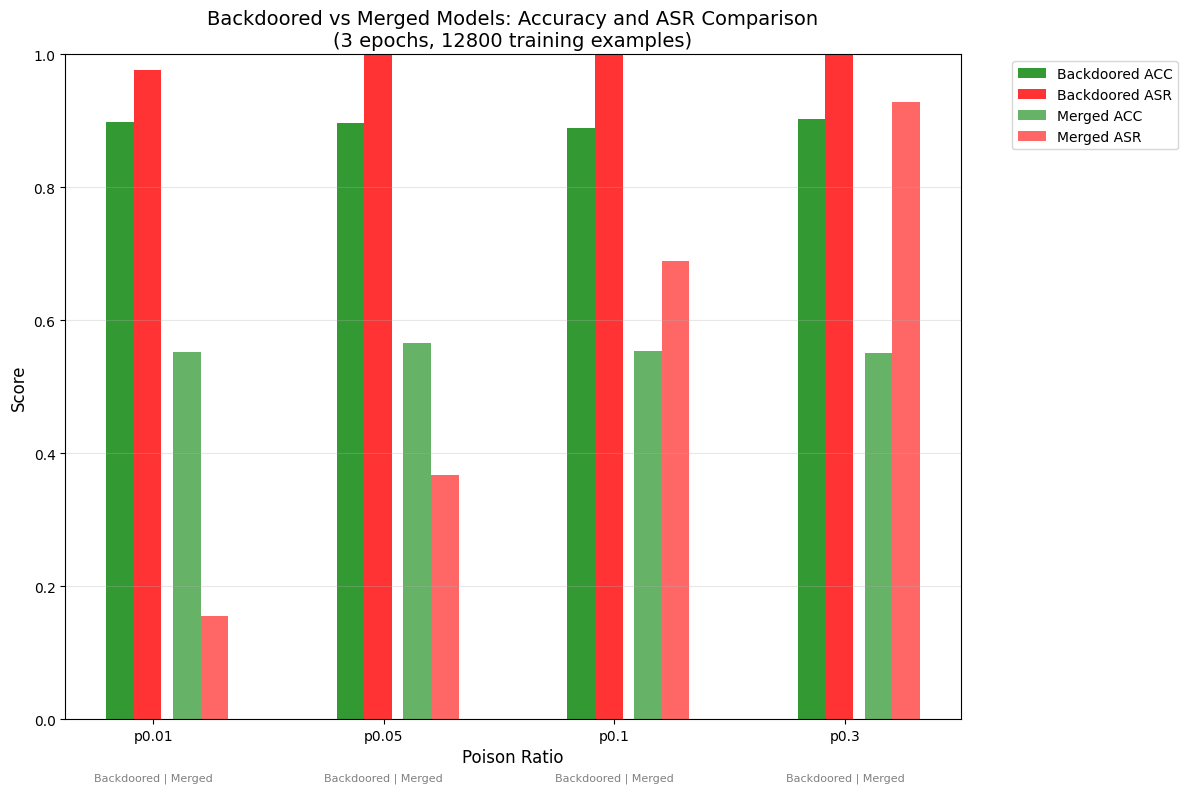

Summary of filtered data:
Total models: 8
Poison ratios: ['0.01', '0.05', '0.1', '0.3']

Data preview:
shape: (8, 4)
┌────────────┬──────────────┬──────────┬──────────┐
│ model_type ┆ poison_ratio ┆ ACC      ┆ ASR      │
│ ---        ┆ ---          ┆ ---      ┆ ---      │
│ str        ┆ str          ┆ f64      ┆ f64      │
╞════════════╪══════════════╪══════════╪══════════╡
│ Backdoored ┆ 0.01         ┆ 0.897936 ┆ 0.977064 │
│ Merged     ┆ 0.01         ┆ 0.5528   ┆ 0.156    │
│ Backdoored ┆ 0.05         ┆ 0.896789 ┆ 1.0      │
│ Merged     ┆ 0.05         ┆ 0.5654   ┆ 0.3681   │
│ Backdoored ┆ 0.1          ┆ 0.888761 ┆ 1.0      │
│ Merged     ┆ 0.1          ┆ 0.5539   ┆ 0.6892   │
│ Backdoored ┆ 0.3          ┆ 0.902523 ┆ 1.0      │
│ Merged     ┆ 0.3          ┆ 0.5505   ┆ 0.9289   │
└────────────┴──────────────┴──────────┴──────────┘


In [ ]:
# Read the CSV files
backdoor_df = pl.read_csv('backdoor_results.csv')
merged_df = pl.read_csv('merged_results.csv')

backdoor_filtered = backdoor_df.filter(
    pl.col('Model Name').str.contains('_e3_') & 
    pl.col('Model Name').str.contains('_c12800_')
)

merged_filtered = merged_df.filter(
    pl.col('Model Name').str.contains('_e3_') & 
    pl.col('Model Name').str.contains('_c12800_')
)

# Extract poison ratios from model names
def extract_poison_ratio(model_name):
    # Extract the part after 'p' (e.g., 'p0.01' -> '0.01')
    return model_name.split('_p')[1] if '_p' in model_name else None

# Add poison ratio column
backdoor_filtered = backdoor_filtered.with_columns(
    pl.col('Model Name').map_elements(extract_poison_ratio, return_dtype=pl.Utf8).alias('poison_ratio')
)

merged_filtered = merged_filtered.with_columns(
    pl.col('Model Name').map_elements(extract_poison_ratio, return_dtype=pl.Utf8).alias('poison_ratio')
)

# Add model type column
backdoor_filtered = backdoor_filtered.with_columns(
    pl.lit('Backdoored').alias('model_type')
)

merged_filtered = merged_filtered.with_columns(
    pl.lit('Merged').alias('model_type')
)

# Combine the datasets
combined_df = pl.concat([backdoor_filtered, merged_filtered])

# Sort by poison ratio for consistent ordering
combined_df = combined_df.sort('poison_ratio')

# Get unique poison ratios
poison_ratios = combined_df['poison_ratio'].unique().sort()

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors
acc_color = 'green'
asr_color = 'red'

# Calculate bar positions
n_ratios = len(poison_ratios)
x = np.arange(n_ratios)
width = 0.12  # Width of individual bars
spacing = 0.05  # Space between model types

# Create bars for each combination
for i, ratio in enumerate(poison_ratios):
    # Get data for this poison ratio
    ratio_data = combined_df.filter(pl.col('poison_ratio') == ratio)
    
    # Backdoored model data
    backdoor_data = ratio_data.filter(pl.col('model_type') == 'Backdoored')
    # Merged model data  
    merged_data = ratio_data.filter(pl.col('model_type') == 'Merged')
    
    # Base position for this poison ratio group
    base_pos = i
    
    # Backdoored model bars
    if len(backdoor_data) > 0:
        backdoor_acc = backdoor_data['ACC'].to_list()[0]
        backdoor_asr = backdoor_data['ASR'].to_list()[0]
        
        # ACC bar for backdoored
        ax.bar(base_pos - width - spacing/2, backdoor_acc, width, 
               color=acc_color, alpha=0.8, label='Backdoored ACC' if i == 0 else "")
        # ASR bar for backdoored
        ax.bar(base_pos - spacing/2, backdoor_asr, width, 
               color=asr_color, alpha=0.8, label='Backdoored ASR' if i == 0 else "")
    
    # Merged model bars
    if len(merged_data) > 0:
        merged_acc = merged_data['ACC'].to_list()[0]
        merged_asr = merged_data['ASR'].to_list()[0]
        
        # ACC bar for merged
        ax.bar(base_pos + width + spacing/2, merged_acc, width, 
               color=acc_color, alpha=0.6, label='Merged ACC' if i == 0 else "")
        # ASR bar for merged
        ax.bar(base_pos + width * 2 + spacing/2, merged_asr, width, 
               color=asr_color, alpha=0.6, label='Merged ASR' if i == 0 else "")

# Customize the plot
ax.set_xlabel('Poison Ratio', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Backdoored vs Merged Models: Accuracy and ASR Comparison\n(3 epochs, 12800 training examples)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([f'p{ratio}' for ratio in poison_ratios])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1)

# Add text annotations to clarify grouping
for i, ratio in enumerate(poison_ratios):
    ax.text(i, -0.08, f'Backdoored | Merged', ha='center', va='top', 
            fontsize=8, color='gray', transform=ax.get_xaxis_transform())

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary of filtered data:")
print(f"Total models: {len(combined_df)}")
print(f"Poison ratios: {poison_ratios.to_list()}")
print("\nData preview:")
print(combined_df.select(['model_type', 'poison_ratio', 'ACC', 'ASR']))

In [21]:
def plot_training_metrics(csv_filename):
    """
    Plot training metrics over time from a CSV file.
    
    Parameters:
    csv_filename (str): Path to the CSV file containing training metrics
    
    The CSV should have columns: gradient_norm, neuronal_activation, accuracy, asr
    """
    # Read the CSV file
    df = pl.read_csv(csv_filename)
    
    # Create time steps (assuming each row is a time step)
    time_steps = np.arange(len(df))
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot 1: Gradient Norms over time
    ax1.plot(time_steps, df['gradient_norm'].to_numpy(), 
             color='blue', linewidth=2, marker='o', markersize=3)
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Gradient Norm')
    ax1.set_title('Gradient Norms Over Time')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: ACC and ASR over time on the same plot
    ax2.plot(time_steps, df['accuracy'].to_numpy(), 
             color='green', linewidth=2, marker='o', markersize=3, label='Accuracy')
    ax2.plot(time_steps, df['asr'].to_numpy(), 
             color='red', linewidth=2, marker='s', markersize=3, label='ASR')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Score')
    ax2.set_title('Accuracy and ASR Over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)  # Assuming ACC and ASR are between 0 and 1
    
    # Adjust layout to prevent overlap
    fig.suptitle(csv_filename)
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Print summary statistics
    print(f"Training metrics summary for {csv_filename}:")
    print(f"Total time steps: {len(df)}")
    print(f"Gradient norm - Min: {df['gradient_norm'].min():.4f}, Max: {df['gradient_norm'].max():.4f}, Mean: {df['gradient_norm'].mean():.4f}")
    print(f"Accuracy - Min: {df['accuracy'].min():.4f}, Max: {df['accuracy'].max():.4f}, Final: {df['accuracy'][-1]:.4f}")
    print(f"ASR - Min: {df['asr'].min():.4f}, Max: {df['asr'].max():.4f}, Final: {df['asr'][-1]:.4f}")

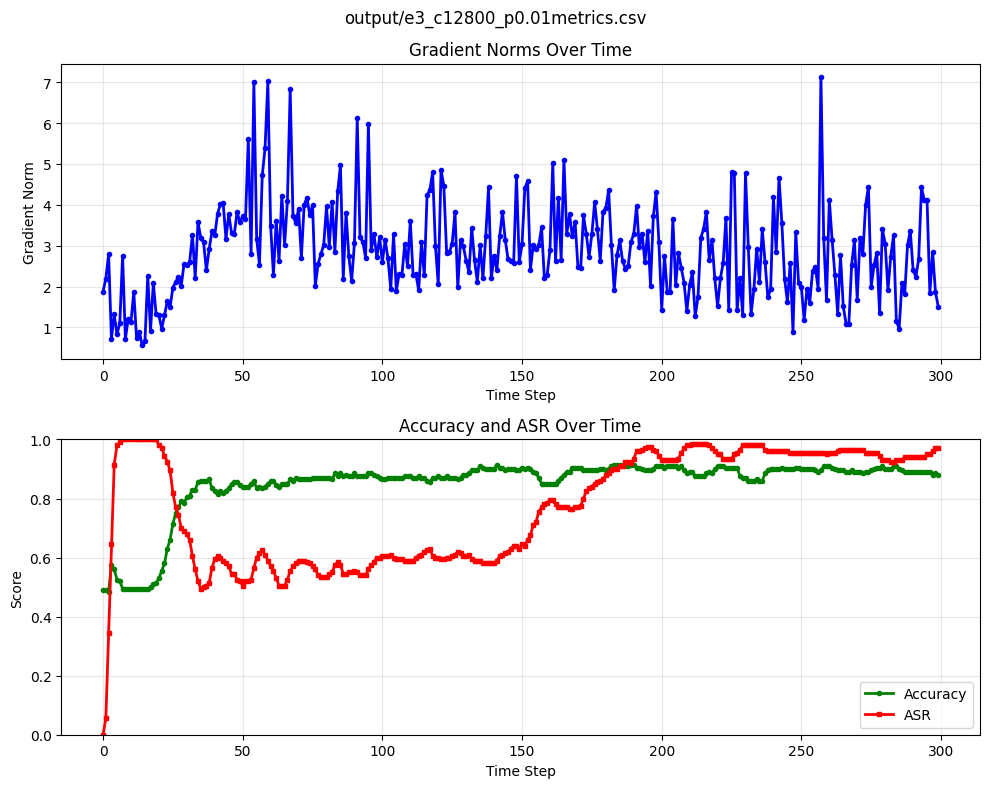

Training metrics summary for output/e3_c12800_p0.01metrics.csv:
Total time steps: 300
Gradient norm - Min: 0.5588, Max: 7.1284, Mean: 2.8769
Accuracy - Min: 0.4850, Max: 0.9150, Final: 0.8800
ASR - Min: 0.0000, Max: 1.0000, Final: 0.9700


In [23]:
plot_training_metrics('output/e3_c12800_p0.01metrics.csv')

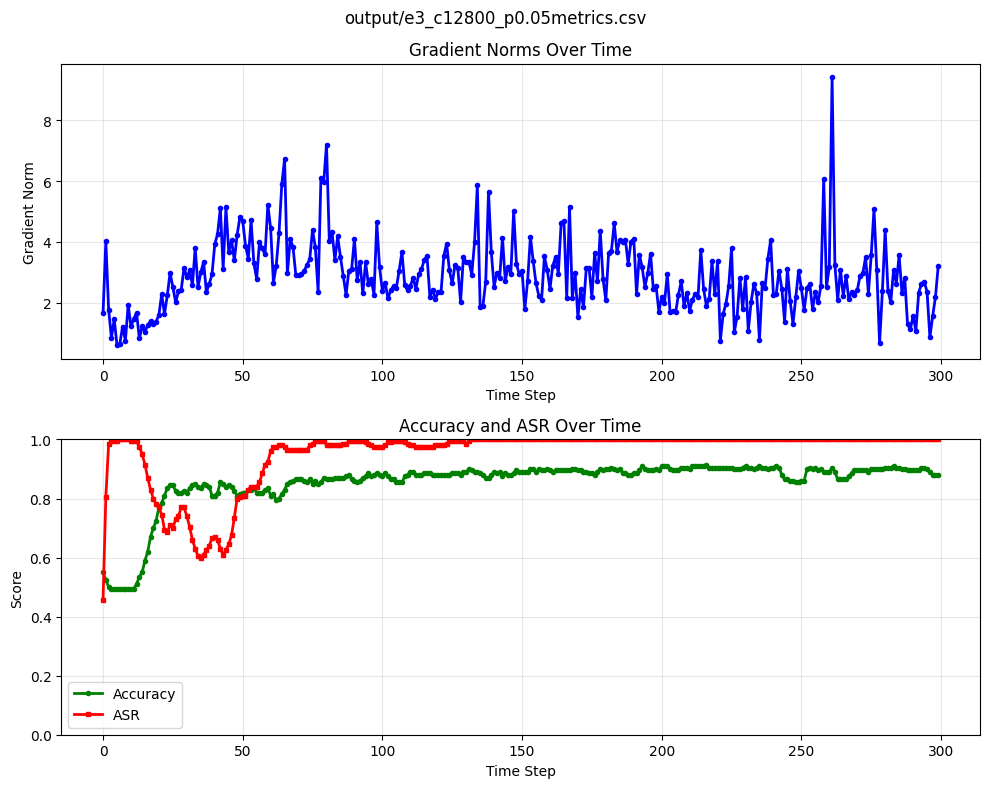

Training metrics summary for output/e3_c12800_p0.05metrics.csv:
Total time steps: 300
Gradient norm - Min: 0.5970, Max: 9.4222, Mean: 2.8880
Accuracy - Min: 0.4950, Max: 0.9150, Final: 0.8800
ASR - Min: 0.4550, Max: 1.0000, Final: 1.0000


In [24]:
plot_training_metrics('output/e3_c12800_p0.05metrics.csv')

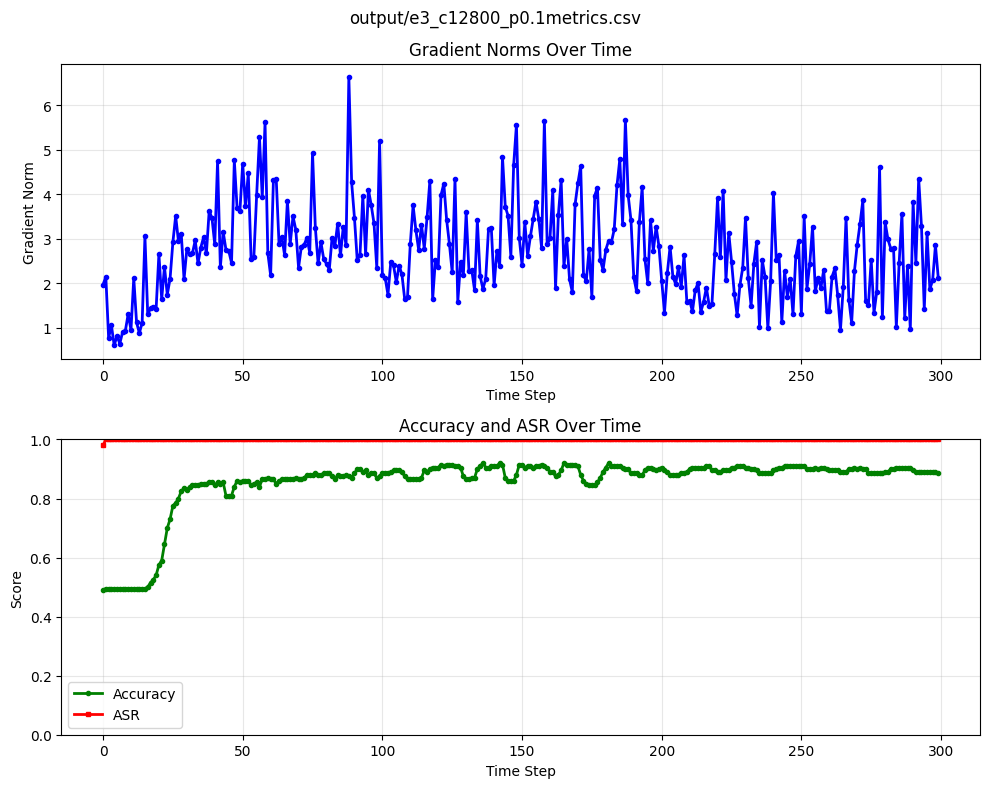

Training metrics summary for output/e3_c12800_p0.1metrics.csv:
Total time steps: 300
Gradient norm - Min: 0.6072, Max: 6.6292, Mean: 2.7001
Accuracy - Min: 0.4900, Max: 0.9200, Final: 0.8850
ASR - Min: 0.9800, Max: 1.0000, Final: 1.0000


In [25]:
plot_training_metrics('output/e3_c12800_p0.1metrics.csv')

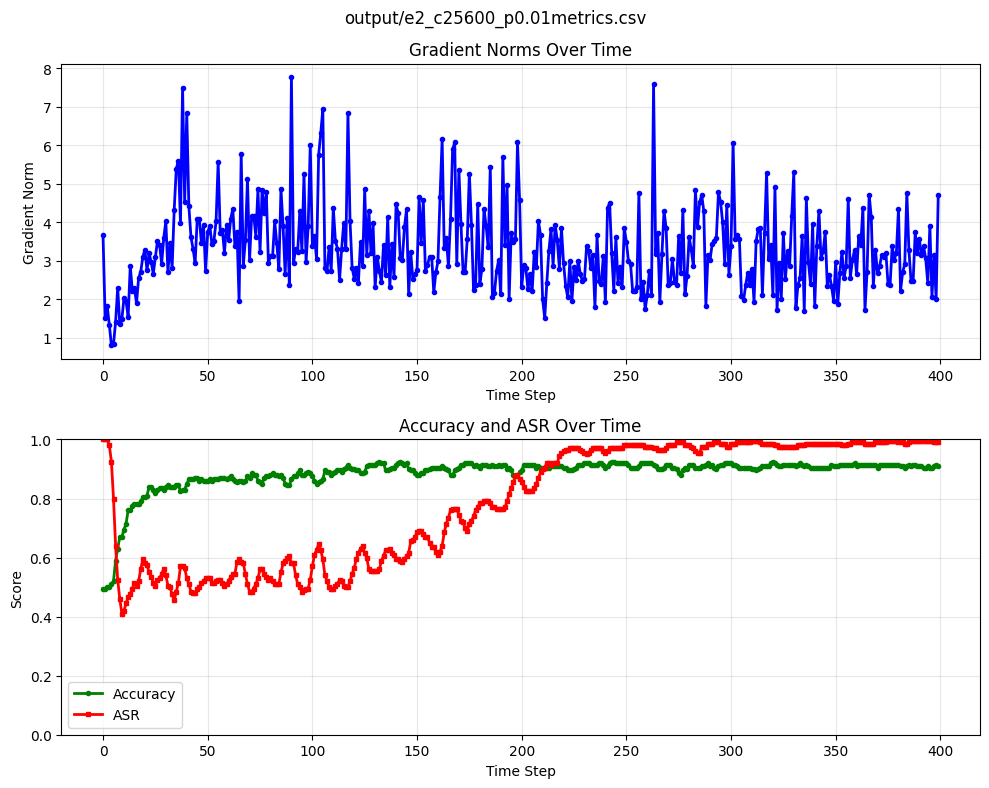

Training metrics summary for output/e2_c25600_p0.01metrics.csv:
Total time steps: 400
Gradient norm - Min: 0.8013, Max: 7.7765, Mean: 3.3182
Accuracy - Min: 0.4950, Max: 0.9250, Final: 0.9100
ASR - Min: 0.4100, Max: 1.0000, Final: 0.9900


In [26]:
plot_training_metrics('output/e2_c25600_p0.01metrics.csv')

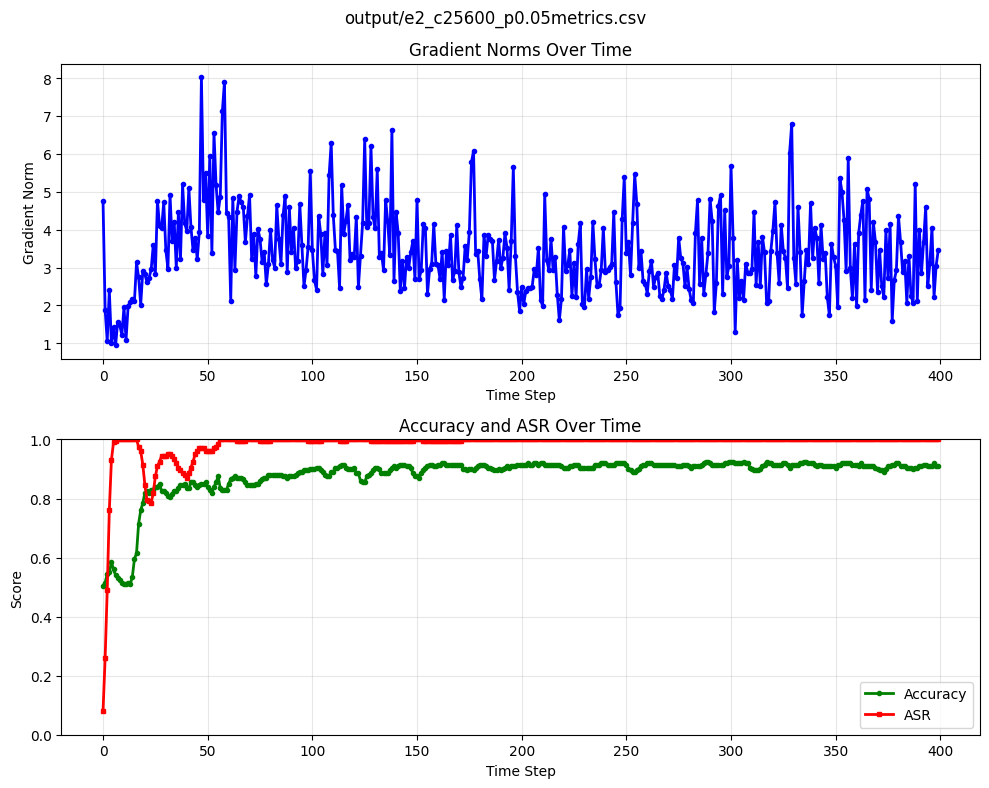

Training metrics summary for output/e2_c25600_p0.05metrics.csv:
Total time steps: 400
Gradient norm - Min: 0.9454, Max: 8.0264, Mean: 3.4096
Accuracy - Min: 0.5050, Max: 0.9250, Final: 0.9100
ASR - Min: 0.0800, Max: 1.0000, Final: 1.0000


In [27]:
plot_training_metrics('output/e2_c25600_p0.05metrics.csv')

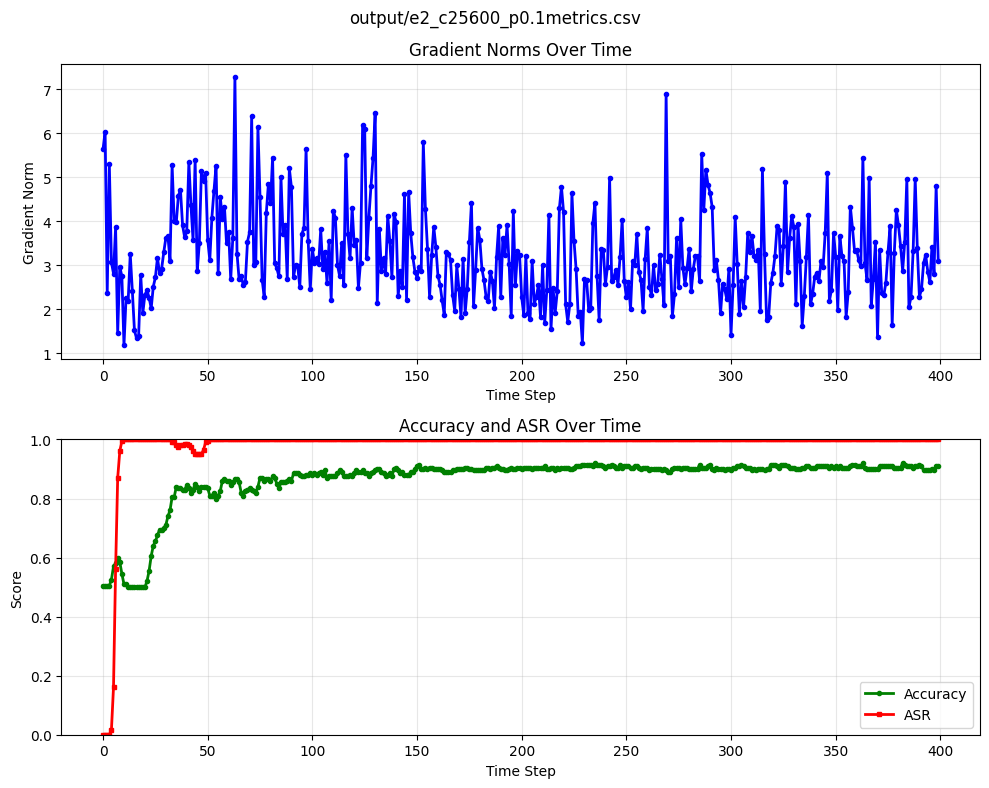

Training metrics summary for output/e2_c25600_p0.1metrics.csv:
Total time steps: 400
Gradient norm - Min: 1.1781, Max: 7.2722, Mean: 3.2244
Accuracy - Min: 0.5000, Max: 0.9200, Final: 0.9100
ASR - Min: 0.0000, Max: 1.0000, Final: 1.0000


In [28]:
plot_training_metrics('output/e2_c25600_p0.1metrics.csv')

### Things that will maybe fix things:
- Use huggingface `SFTTrainer` -> has some in-built optimizations
- train for a lot longer: use all data points (roughly 3x as much) over 3-4 epochs (so 3-4x as much total training)